In [1]:
!pip install tensorflow keras opencv-python scikit-learn


In [1]:
import cv2
import os

def extract_frames(video_path, output_dir, frame_rate=1):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    cap = cv2.VideoCapture(video_path)
    count = 0
    success = True

    while success:
        success, image = cap.read()
        if count % frame_rate == 0 and success:
            cv2.imwrite(os.path.join(output_dir, f"frame{count}.jpg"), image)
        count += 1
    cap.release()

video_path = r'C:\Users\Sandhya\Desktop\sih\Celeb-DF\Celeb-real\id0_0000.mp4'
output_dir = r'C:\Users\Sandhya\Desktop\sih\frames\celeb_real'

extract_frames(video_path, output_dir)


In [13]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Flatten, TimeDistributed
from tensorflow.keras.models import Model

def build_resnet50_lstm_model():
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        TimeDistributed(base_model, input_shape=(None, 224, 224, 3)),
        TimeDistributed(Flatten()),
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    return model

model = build_resnet50_lstm_model()
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDi  (None, None, 7, 7, 2048   23587712  
 stributed)                  )                                   
                                                                 
 time_distributed_3 (TimeDi  (None, None, 100352)      0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 64)                25706752  
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 49298689 (188.06 MB)
Trainable params: 2

In [15]:
import pandas as pd

def create_dataframe_from_folders(base_path, folders_with_labels):
    video_paths = []
    labels = []
    
    for folder, label in folders_with_labels:
        folder_path = os.path.join(base_path, folder)
        for video_file in os.listdir(folder_path):
            if video_file.endswith('.mp4'):
                video_paths.append(os.path.join(folder_path, video_file))
                labels.append(label)
    
    df = pd.DataFrame({
        'video_path': video_paths,
        'label': labels
    })
    
    return df

base_path = r'C:\Users\Sandhya\Desktop\sih\Celeb-DF'
folders_with_labels = [
    ('YouTube-real', 1),
    ('Celeb-real', 1),
    ('Celeb-synthesis', 0)
]

df = create_dataframe_from_folders(base_path, folders_with_labels)
df.to_csv(r'C:\Users\Sandhya\Desktop\sih\processed_videos.csv', index=False)


In [17]:
from sklearn.model_selection import train_test_split

metadata = pd.read_csv(r'C:\Users\Sandhya\Desktop\sih\processed_videos.csv')
train_data, test_data = train_test_split(metadata, test_size=0.2, random_state=42)

train_data.to_csv(r'C:\Users\Sandhya\Desktop\sih\train_videos.csv', index=False)
test_data.to_csv(r'C:\Users\Sandhya\Desktop\sih\test_videos.csv', index=False)


In [ ]:
import numpy as np
import cv2
import os

def video_data_generator(data, batch_size=32, frame_dir=r'C:\Users\Sandhya\Desktop\sih\frames', num_frames=30):
    while True:
        for idx in range(0, len(data), batch_size):
            batch = data.iloc[idx:idx + batch_size]
            X = []
            y = []
            for _, row in batch.iterrows():
                video_path = row['video_path']
                label = row['label']

                temp_frame_dir = os.path.join(frame_dir, str(idx))
                if os.path.exists(temp_frame_dir):
                    for f in os.listdir(temp_frame_dir):
                        os.remove(os.path.join(temp_frame_dir, f))
                else:
                    os.makedirs(temp_frame_dir)

                # Extract frames from video
                extract_frames(video_path, temp_frame_dir)

                # Read and process frames
                frames = [cv2.imread(os.path.join(temp_frame_dir, frame)) for frame in sorted(os.listdir(temp_frame_dir))]
                frames = [cv2.resize(frame, (224, 224)) for frame in frames]
                
                # Pad or truncate frames to ensure uniform number of frames per video
                if len(frames) < num_frames:
                    frames += [np.zeros((224, 224, 3))] * (num_frames - len(frames))
                else:
                    frames = frames[:num_frames]
                
                # Normalize the frames
                frames = np.array(frames) / 255.0

                X.append(frames)
                y.append(label)
            
            if X:
                yield np.array(X), np.array(y)


In [48]:
import os
import cv2

def extract_frames(video_path, output_dir, frame_rate=1):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cap = cv2.VideoCapture(video_path)
    
    # Check if the video was opened successfully
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return

    count = 0
    success = True

    while success:
        success, image = cap.read()

        # Check if the frame was read successfully
        if success and count % frame_rate == 0:
            frame_path = os.path.join(output_dir, f"{os.path.basename(video_path)}_frame{count}.jpg")
            try:
                cv2.imwrite(frame_path, image)
            except Exception as e:
                print(f"Error writing frame {count}: {e}")
        count += 1

    cap.release()
    print(f"Frames extracted for video: {video_path}")

# Paths for the directories in Jupyter
video_dir = r"C:\Users\Sandhya\Desktop\sih\Celeb-DF\Celeb-real" # Replace with your actual directory
output_dir_base = r"C:\Users\Sandhya\Desktop\sih\frames\celeb-real"  # Base output directory

# Loop over all videos in the directory
for video_file in os.listdir(video_dir):
    video_path = os.path.join(video_dir, video_file)

    # Make sure the file is a video (check the extension)
    if video_file.endswith(('.mp4', '.avi', '.mov')):  # Add other video formats if necessary
        output_dir = os.path.join(output_dir_base, os.path.splitext(video_file)[0])
        extract_frames(video_path, output_dir, frame_rate=1)  # Extract frames for each video


Frames extracted for video: C:\Users\Sandhya\Desktop\sih\Celeb-DF\Celeb-real\id0_0000.mp4
Frames extracted for video: C:\Users\Sandhya\Desktop\sih\Celeb-DF\Celeb-real\id0_0001.mp4
Frames extracted for video: C:\Users\Sandhya\Desktop\sih\Celeb-DF\Celeb-real\id0_0002.mp4
Frames extracted for video: C:\Users\Sandhya\Desktop\sih\Celeb-DF\Celeb-real\id0_0003.mp4
Frames extracted for video: C:\Users\Sandhya\Desktop\sih\Celeb-DF\Celeb-real\id0_0004.mp4
Frames extracted for video: C:\Users\Sandhya\Desktop\sih\Celeb-DF\Celeb-real\id0_0005.mp4
Frames extracted for video: C:\Users\Sandhya\Desktop\sih\Celeb-DF\Celeb-real\id0_0006.mp4
Frames extracted for video: C:\Users\Sandhya\Desktop\sih\Celeb-DF\Celeb-real\id0_0007.mp4
Frames extracted for video: C:\Users\Sandhya\Desktop\sih\Celeb-DF\Celeb-real\id0_0008.mp4
Frames extracted for video: C:\Users\Sandhya\Desktop\sih\Celeb-DF\Celeb-real\id0_0009.mp4
Frames extracted for video: C:\Users\Sandhya\Desktop\sih\Celeb-DF\Celeb-real\id10_0000.mp4
Frames ex

KeyboardInterrupt: 

In [64]:
import os
import cv2

def extract_frames(video_path, output_dir, frame_rate=1):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cap = cv2.VideoCapture(video_path)
    
    # Check if the video was opened successfully
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return

    count = 0
    success = True
    existing_frames = set(os.path.basename(f).split('_frame')[1].split('.jpg')[0] for f in os.listdir(output_dir) if '_frame' in f)

    while success:
        success, image = cap.read()

        # Check if the frame was read successfully
        if success and count % frame_rate == 0:
            frame_number = count
            if str(frame_number) in existing_frames:
                print(f"Frame {frame_number} already extracted for video {video_path}")
            else:
                frame_path = os.path.join(output_dir, f"{os.path.basename(video_path)}_frame{frame_number}.jpg")
                try:
                    cv2.imwrite(frame_path, image)
                except Exception as e:
                    print(f"Error writing frame {frame_number}: {e}")
                print(f"Extracted frame {frame_number} from video {video_path}")
        count += 1

    cap.release()
    print(f"Frames extraction completed for video: {video_path}")

# Paths for the directories in Jupyter
video_dir = r"C:\Users\Sandhya\Desktop\sih\Celeb-DF\Celeb-real" # Replace with your actual directory
output_dir_base = r"C:\Users\Sandhya\Desktop\sih\frames\celeb-real"  # Base output directory

# Loop over all videos in the directory
for video_file in os.listdir(video_dir):
    video_path = os.path.join(video_dir, video_file)

    # Make sure the file is a video (check the extension)
    if video_file.endswith(('.mp4', '.avi', '.mov')):  # Add other video formats if necessary
        output_dir = os.path.join(output_dir_base, os.path.splitext(video_file)[0])
        extract_frames(video_path, output_dir, frame_rate=1)  # Extract frames for each video


Frame 0 already extracted for video C:\Users\Sandhya\Desktop\sih\Celeb-DF\Celeb-real\id0_0000.mp4
Extracted frame 1 from video C:\Users\Sandhya\Desktop\sih\Celeb-DF\Celeb-real\id0_0000.mp4
Frame 2 already extracted for video C:\Users\Sandhya\Desktop\sih\Celeb-DF\Celeb-real\id0_0000.mp4
Extracted frame 3 from video C:\Users\Sandhya\Desktop\sih\Celeb-DF\Celeb-real\id0_0000.mp4
Frame 4 already extracted for video C:\Users\Sandhya\Desktop\sih\Celeb-DF\Celeb-real\id0_0000.mp4
Frame 5 already extracted for video C:\Users\Sandhya\Desktop\sih\Celeb-DF\Celeb-real\id0_0000.mp4
Extracted frame 6 from video C:\Users\Sandhya\Desktop\sih\Celeb-DF\Celeb-real\id0_0000.mp4
Extracted frame 7 from video C:\Users\Sandhya\Desktop\sih\Celeb-DF\Celeb-real\id0_0000.mp4
Frame 8 already extracted for video C:\Users\Sandhya\Desktop\sih\Celeb-DF\Celeb-real\id0_0000.mp4
Frame 9 already extracted for video C:\Users\Sandhya\Desktop\sih\Celeb-DF\Celeb-real\id0_0000.mp4
Extracted frame 10 from video C:\Users\Sandhya\D

KeyboardInterrupt: 

In [70]:
import numpy as np
import cv2
import os 

def extract_frames(video_path, output_dir, frame_rate=1):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cap = cv2.VideoCapture(video_path)
    
    # Check if the video was opened successfully
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return

    count = 0
    success = True

    while success:
        success, image = cap.read()

        # Check if the frame was read successfully
        if success and count % frame_rate == 0:
            frame_path = os.path.join(output_dir, f"{os.path.basename(video_path)}_frame{count}.jpg")
            try:
                cv2.imwrite(frame_path, image)
            except Exception as e:
                print(f"Error writing frame {count}: {e}")
        count += 1

    cap.release()
    print(f"Frames extracted for video: {video_path}, total frames: {count}")

def video_data_generator(data, batch_size=32, frame_dir=r'C:\Users\Sandhya\Desktop\sih\frames', num_frames=15):
    while True:
        for idx in range(0, len(data), batch_size):
            batch = data.iloc[idx:idx + batch_size]
            X = []
            y = []
            for _, row in batch.iterrows():
                video_path = row['video_path']
                label = row['label']

                temp_frame_dir = os.path.join(frame_dir, str(idx))
                if os.path.exists(temp_frame_dir):
                    # Ensure directory is cleaned before extracting new frames
                    for f in os.listdir(temp_frame_dir):
                        os.remove(os.path.join(temp_frame_dir, f))
                else:
                    os.makedirs(temp_frame_dir)

                # Extract frames from video
                extract_frames(video_path, temp_frame_dir)

                # Read and process frames
                frames = [cv2.imread(os.path.join(temp_frame_dir, frame)) for frame in sorted(os.listdir(temp_frame_dir))]
                frames = [cv2.resize(frame, (224, 224)) for frame in frames if frame is not None]

                print(f"Processed video: {video_path}, extracted frames: {len(frames)}")

                # Pad or truncate frames to ensure uniform number of frames per video
                if len(frames) < num_frames:
                    frames += [np.zeros((224, 224, 3))] * (num_frames - len(frames))
                else:
                    frames = frames[:num_frames]
                
                # Normalize the frames
                frames = np.array(frames) / 255.0

                X.append(frames)
                y.append(label)
            
            if X:
                print(f"Batch {idx // batch_size + 1}: Number of videos processed: {len(X)}")
                yield np.array(X), np.array(y)


In [76]:
import tensorflow as tf
import numpy as np
import os
import cv2

def extract_frames(video_path, output_dir, frame_rate=1):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cap = cv2.VideoCapture(video_path)
    
    # Check if the video was opened successfully
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return

    count = 0
    success = True

    while success:
        success, image = cap.read()

        # Check if the frame was read successfully
        if success and count % frame_rate == 0:
            frame_path = os.path.join(output_dir, f"{os.path.basename(video_path)}_frame{count}.jpg")
            try:
                cv2.imwrite(frame_path, image)
            except Exception as e:
                print(f"Error writing frame {count}: {e}")
        count += 1

    cap.release()
    print(f"Frames extracted for video: {video_path}, total frames: {count}")

def video_data_generator(data, batch_size=8, frame_dir=r'C:\Users\Sandhya\Desktop\sih\frames', num_frames=10):
    while True:
        for idx in range(0, len(data), batch_size):
            batch = data.iloc[idx:idx + batch_size]
            X = []
            y = []
            for _, row in batch.iterrows():
                video_path = row['video_path']
                label = row['label']

                temp_frame_dir = os.path.join(frame_dir, str(idx))
                if os.path.exists(temp_frame_dir):
                    # Ensure directory is cleaned before extracting new frames
                    for f in os.listdir(temp_frame_dir):
                        os.remove(os.path.join(temp_frame_dir, f))
                else:
                    os.makedirs(temp_frame_dir)

                # Extract frames from video
                extract_frames(video_path, temp_frame_dir)

                # Read and process frames
                frames = [cv2.imread(os.path.join(temp_frame_dir, frame)) for frame in sorted(os.listdir(temp_frame_dir))]
                frames = [cv2.resize(frame, (224, 224)) for frame in frames if frame is not None]

                print(f"Processed video: {video_path}, extracted frames: {len(frames)}")

                # Pad or truncate frames to ensure uniform number of frames per video
                if len(frames) < num_frames:
                    frames += [np.zeros((224, 224, 3))] * (num_frames - len(frames))
                else:
                    frames = frames[:num_frames]
                
                # Normalize the frames
                frames = np.array(frames) / 255.0

                X.append(frames)
                y.append(label)
            
            if X:
                print(f"Batch {idx // batch_size + 1}: Number of videos processed: {len(X)}")
                yield np.array(X), np.array(y)

def build_resnext50_lstm_model(num_frames=10):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(num_frames, 224, 224, 3))
    x = tf.keras.layers.TimeDistributed(base_model)(inputs)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(x)
    x = tf.keras.layers.LSTM(128)(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, x)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Build and compile the model
model = build_resnext50_lstm_model(num_frames=10)
model.summary()

# Set up data generators
train_gen = video_data_generator(train_data, batch_size=8, num_frames=10)
val_gen = video_data_generator(test_data, batch_size=8, num_frames=10)

# Train the model
model.fit(
    train_gen, 
    validation_data=val_gen, 
    steps_per_epoch=len(train_data) // 8, 
    validation_steps=len(test_data) // 8, 
    epochs=10
)


Frames extracted for video: C:\Users\Sandhya\Desktop\sih\Celeb-DF\Celeb-synthesis\id0_id2_0000.mp4, total frames: 470



KeyboardInterrupt



In [100]:
# import tensorflow as tf

# # Build a smaller and faster model using MobileNetV2
# def build_mobilenetv2_lstm_model():
#     base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
#     base_model.trainable = False

#     inputs = tf.keras.Input(shape=(None, 224, 224, 3))
#     x = tf.keras.layers.TimeDistributed(base_model)(inputs)
#     x = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(x)
#     x = tf.keras.layers.LSTM(128, return_sequences=False)(x)
#     x = tf.keras.layers.Dropout(0.5)(x)  # Dropout to prevent overfitting
#     x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

#     model = tf.keras.Model(inputs, x)
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
#     return model


# # Build and compile the smaller and faster model
# model = build_mobilenetv2_lstm_model()

# import pandas as pd
# from sklearn.model_selection import train_test_split

# # Load metadata
# metadata = pd.read_csv(r'C:\Users\Sandhya\Desktop\sih\processed_videos.csv')
# train_data, test_data = train_test_split(metadata, test_size=0.2, random_state=42)

# train_data.to_csv(r'C:\Users\Sandhya\Desktop\sih\train_videos.csv', index=False)
# test_data.to_csv(r'C:\Users\Sandhya\Desktop\sih\test_videos.csv', index=False)

# # Modify the video_data_generator function to sample frames more efficiently
# import cv2
# import os
# import numpy as np

# def video_data_generator(data, batch_size, num_frames=30, frame_step=5):
#     while True:
#         for start in range(0, len(data), batch_size):
#             batch_data = data[start:start + batch_size]
#             video_frames = []
#             labels = []
            
#             for _, row in batch_data.iterrows():
#                 video_path = row['video_path']  # Assuming this column contains paths
#                 label = row['label']  # Assuming this column contains labels
                
#                 # Load video
#                 cap = cv2.VideoCapture(video_path)
#                 frames = []
#                 frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                
#                 # Sample frames using frame_step
#                 for i in range(0, frame_count, frame_step):
#                     cap.set(cv2.CAP_PROP_POS_FRAMES, i)
#                     ret, frame = cap.read()
#                     if not ret:
#                         break
#                     frame = cv2.resize(frame, (224, 224))  # Resize to (224, 224)
#                     frames.append(frame)
#                     if len(frames) == num_frames:
#                         break
                
#                 cap.release()

#                 # Pad if there are fewer than num_frames
#                 if len(frames) < num_frames:
#                     frames += [np.zeros((224, 224, 3))] * (num_frames - len(frames))

#                 video_frames.append(frames)
#                 labels.append(label)

#             # Convert to numpy arrays
#             video_frames = np.array(video_frames)
#             labels = np.array(labels)

#             yield video_frames, labels


# # Use a reduced number of frames (e.g., 30)
# train_gen = video_data_generator(train_data, batch_size=8, num_frames=30, frame_step=5)
# val_gen = video_data_generator(test_data, batch_size=8, num_frames=30, frame_step=5)

# # Train the model, displaying only epoch lines and reducing unnecessary output
# model.fit(
#     train_gen, 
#     validation_data=val_gen, 
#     steps_per_epoch=len(train_data) // 8, 
#     validation_steps=len(test_data) // 8, 
#     epochs=10,
#     verbose=1  # Only epoch information
# )


PermissionError: [Errno 13] Permission denied: 'C:\\Users\\Sandhya\\Desktop\\sih\\train_videos.csv'

Epoch 1/10
120/120 [==============================] - 985s 8s/step - loss: 1.2498 - accuracy: 0.6354 - val_loss: 1.0139 - val_accuracy: 0.6417
Epoch 2/10
120/120 [==============================] - 1255s 11s/step - loss: 0.9464 - accuracy: 0.6447 - val_loss: 0.8786 - val_accuracy: 0.6352
Epoch 3/10
120/120 [==============================] - 4794s 40s/step - loss: 0.8785 - accuracy: 0.6447 - val_loss: 0.8161 - val_accuracy: 0.6352
Epoch 4/10
120/120 [==============================] - 7600s 64s/step - loss: 0.8217 - accuracy: 0.6572 - val_loss: 0.7724 - val_accuracy: 0.6395
Epoch 5/10
120/120 [==============================] - 702s 6s/step - loss: 0.7716 - accuracy: 0.6834 - val_loss: 0.7435 - val_accuracy: 0.6609
Epoch 6/10
120/120 [==============================] - 669s 6s/step - loss: 0.7053 - accuracy: 0.7222 - val_loss: 0.7172 - val_accuracy: 0.6567
Epoch 7/10
120/120 [==============================] - 1336s 11s/step - loss: 0.6872 - accuracy: 0.7264 - val_loss: 0.6986 - val_accuracy

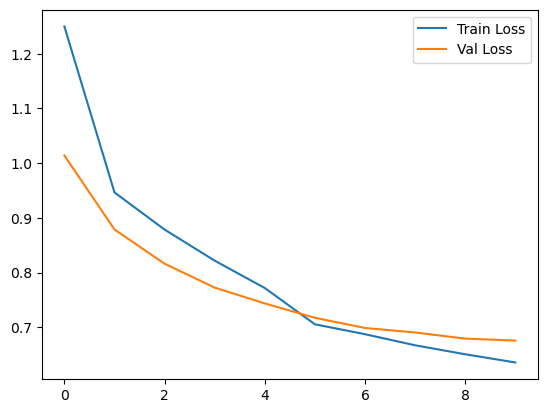

In [112]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Build a smaller and faster model using MobileNetV2 with added regularization
def build_mobilenetv2_lstm_model():
    base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the base model layers

    inputs = tf.keras.Input(shape=(None, 224, 224, 3))
    x = tf.keras.layers.TimeDistributed(base_model)(inputs)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(x)
    x = tf.keras.layers.LSTM(128, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)  # L2 regularization in LSTM
    x = tf.keras.layers.Dropout(0.5)(x)  # Dropout to prevent overfitting
    x = tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)  # L2 Regularization in Dense layer

    model = tf.keras.Model(inputs, x)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Adjusted learning rate
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Build and compile the model
model = build_mobilenetv2_lstm_model()

# Load metadata
metadata = pd.read_csv(r'C:\Users\Sandhya\Desktop\sih\processed_videos.csv')
train_data, test_data = train_test_split(metadata, test_size=0.2, random_state=42)

train_data.to_csv(r"C:\Users\Sandhya\Desktop\sih\train_videos.csv", index=False)
test_data.to_csv(r'C:\Users\Sandhya\Desktop\sih\test_videos.csv', index=False)

# Modify the video_data_generator function to include data augmentation
def video_data_generator(data, batch_size, num_frames=30, frame_step=5):
    while True:
        for start in range(0, len(data), batch_size):
            batch_data = data[start:start + batch_size]
            video_frames = []
            labels = []

            for _, row in batch_data.iterrows():
                video_path = row['video_path']
                label = row['label']
                
                # Load video
                cap = cv2.VideoCapture(video_path)
                frames = []
                frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

                for i in range(0, frame_count, frame_step):
                    cap.set(cv2.CAP_PROP_POS_FRAMES, i)
                    ret, frame = cap.read()
                    if not ret:
                        break
                    frame = cv2.resize(frame, (224, 224))

                    # Data augmentation: random horizontal flip
                    if np.random.rand() > 0.5:
                        frame = cv2.flip(frame, 1)

                    frames.append(frame)
                    if len(frames) == num_frames:
                        break

                cap.release()

                if len(frames) < num_frames:
                    frames += [np.zeros((224, 224, 3))] * (num_frames - len(frames))

                video_frames.append(frames)
                labels.append(label)

            video_frames = np.array(video_frames)
            labels = np.array(labels)

            yield video_frames, labels

# Create training and validation generators
train_gen = video_data_generator(train_data, batch_size=8, num_frames=30, frame_step=5)
val_gen = video_data_generator(test_data, batch_size=8, num_frames=30, frame_step=5)

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    train_gen, 
    validation_data=val_gen, 
    steps_per_epoch=len(train_data) // 8, 
    validation_steps=len(test_data) // 8, 
    epochs=10,
    callbacks=[early_stopping],  
    verbose=1  
)

# Plotting the loss to check for overfitting
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()


In [104]:
# Assuming `test_data` contains paths to your test videos and labels
test_gen = video_data_generator(test_data, batch_size=8, frame_dir=r'C:\Users\Sandhya\Desktop\sih\frames')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_gen, steps=len(test_data) // 8)
print(f"Test Accuracy: {test_accuracy}")


TypeError: video_data_generator() got an unexpected keyword argument 'frame_dir'

In [114]:
# Save the model in the native Keras format
model.save('my_model.keras')

In [ ]:
def predict_video(video_path, frame_dir=r'C:\Users\Sandhya\Desktop\sih\frames'):
    # Extract frames from the video
    temp_frame_dir = os.path.join(frame_dir, "temp")
    if not os.path.exists(temp_frame_dir):
        os.makedirs(temp_frame_dir)
    
    extract_frames(video_path, temp_frame_dir)

    # Load and preprocess the frames
    frames = [cv2.imread(os.path.join(temp_frame_dir, frame)) for frame in sorted(os.listdir(temp_frame_dir))]
    frames = [cv2.resize(frame, (224, 224)) for frame in frames]
    frames = np.array(frames) / 255.0  # Normalize the frames

    # Make prediction
    frames = np.expand_dims(frames, axis=0)  # Add batch dimension
    prediction = model.predict(frames)

    # Remove temporary frames
    for f in os.listdir(temp_frame_dir):
        os.remove(os.path.join(temp_frame_dir, f))
    
    return "Fake" if prediction < 0.5 else "Real"

# Example usage
video_path = r'C:\Users\Sandhya\Desktop\sih\test_videos\example_video.mp4'
result = predict_video(video_path)
print(f"Prediction: {result}")


In [ ]:
# TESTING

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('model.h5')

# Now, you can test or predict using the loaded model


In [ ]:
test_gen = video_data_generator(test_data, batch_size=8, frame_dir=r'C:\Users\Sandhya\Desktop\sih\frames')


In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_gen, steps=len(test_data) // 8)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


In [ ]:
import numpy as np
import cv2
import os

def predict_video(video_path, model, frame_dir=r'C:\Users\Sandhya\Desktop\sih\frames'):
    # Extract frames from the video
    temp_frame_dir = os.path.join(frame_dir, "temp")
    if not os.path.exists(temp_frame_dir):
        os.makedirs(temp_frame_dir)
    
    extract_frames(video_path, temp_frame_dir)

    # Load and preprocess the frames
    frames = [cv2.imread(os.path.join(temp_frame_dir, frame)) for frame in sorted(os.listdir(temp_frame_dir))]
    frames = [cv2.resize(frame, (224, 224)) for frame in frames]
    frames = np.array(frames) / 255.0  # Normalize the frames

    # Make prediction
    frames = np.expand_dims(frames, axis=0)  # Add batch dimension
    prediction = model.predict(frames)

    # Remove temporary frames
    for f in os.listdir(temp_frame_dir):
        os.remove(os.path.join(temp_frame_dir, f))
    
    return "Fake" if prediction < 0.5 else "Real"

# Example usage with a test video path
video_path = r'C:\Users\Sandhya\Desktop\sih\test_videos\example_video.mp4'
result = predict_video(video_path, model)
print(f"Prediction: {result}")
